In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Image
import scipy.stats as stats

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MmhcEstimator, HillClimbSearch, ConstraintBasedEstimator
from pgmpy.estimators import BdeuScore, K2Score, BicScore
import networkx as nx

%matplotlib inline

In [2]:
data = pd.read_csv('../data/so.csv')
data = data[data.gender.isin(['Male', 'Female', 'Other'])]

data = data.dropna(subset=['salary_range'])
data = data[data['salary_range'].str.contains('\$')]
data['desktop_os'] = data['desktop_os'].str.replace('Ubuntu|Debian|Fedora|Mint|Other Linux', 'Linux')
data['desktop_os'] = data['desktop_os'].str.replace('Windows.*', 'Windows')
data['is_javascript'] = data['tech_do'].str.contains('JavaScript').apply(lambda x: str(x) if not x == np.nan else np.nan)
data['is_php'] = data['tech_do'].str.contains('PHP').apply(lambda x: str(x) if not x == np.nan else np.nan)
data['is_python'] = data['tech_do'].str.contains('Python').apply(lambda x: str(x) if not x == np.nan else np.nan)
data['salary_range'] = data.salary_range.str.replace('\$[0-9]{3},000 - \$[0-9]{3},000', 'More than $100,000')
data['salary_range'] = data.salary_range.str.replace('More than \$200,000', 'More than $100,000')
data = data[['age_range', 'star_wars_vs_star_trek', 'experience_range', 
            'salary_range', 'gender', 'so_region', 'agree_diversity',
            'is_javascript', 'is_php', 'is_python', 'desktop_os']]
def ev(dictionary):
    return {k: list(data[k].unique()).index(v) for k,v in dictionary.items()}

In [3]:
data.head()

,age_range,star_wars_vs_star_trek,experience_range,salary_range,gender,so_region,agree_diversity,is_javascript,is_php,is_python,desktop_os
1,30-34,Star Wars,6 - 10 years,"$40,000 - $50,000",Male,Central Asia,Agree somewhat,False,False,False,Mac OS X
3,NaN,NaN,11+ years,"Less than $10,000",Female,Central Asia,Agree somewhat,nan,nan,nan,Linux
6,Prefer not to disclose,NaN,11+ years,"More than $100,000",Other,Central Asia,NaN,True,True,True,Windows
7,25-29,NaN,1 - 2 years,"Less than $10,000",Male,Central Asia,Disagree completely,True,True,False,Windows
9,20-24,NaN,1 - 2 years,"Less than $10,000",Male,Eastern Europe,Agree somewhat,False,True,False,Windows


In [25]:
bic = BicScore(data)
k2 = K2Score(data)
bdeu = BdeuScore(data)

def print_scores(model):
    bic_s, k2_s, bdeu_s = [m.score(model) for m in (bic, k2, bdeu)]
    print('BIC:', bic_s)
    print('K2:', k2_s)
    print('BDeu:', bdeu_s)
    return bic_s, k2_s, bdeu_s

In [14]:
handcrafted_model = BayesianModel([('age_range', 'star_wars_vs_star_trek'), 
                       ('age_range', 'experience_range'),
                       ('experience_range', 'salary_range'),
                       ('gender', 'salary_range'),
                       ('so_region', 'salary_range'),
                       ('gender', 'agree_diversity'),
                       ('agree_diversity', 'is_javascript'),
                       ('agree_diversity', 'is_php'),
                       ('agree_diversity', 'is_python'),
                       ('so_region', 'desktop_os'),
                       ('desktop_os', 'is_javascript'),
                       ('desktop_os', 'is_php'),
                       ('desktop_os', 'is_python'),
                       ('is_javascript', 'salary_range'),
                       ('is_php', 'salary_range'),
                       ('is_python', 'salary_range'),
                       ('age_range', 'desktop_os'),
                       ('so_region', 'agree_diversity'),])

print_scores(handcrafted_model)

BIC: -602925.608607
K2: -327627.79778648
BDeu: -344039.1397385946


In [15]:
def draw_graph(model):
    G = nx.DiGraph()
    G.add_nodes_from(data.columns)
    G.add_edges_from(model.edges())

    plt.figure(figsize=(10, 10))
    layout = nx.fruchterman_reingold_layout(G)
    nx.draw(G, pos=layout, with_labels=True, alpha=0.2, arrows=True)

  0%|                                                                                                                                                                                                                 | 0/10 [00:00<?, ?it/s]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


 10%|████████████████████                                                                                                                                                                                     | 1/10 [01:13<11:05, 73.89s/it]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


 20%|████████████████████████████████████████▏                                                                                                                                                                | 2/10 [02:27<09:51, 73.93s/it]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


 30%|████████████████████████████████████████████████████████████▎                                                                                                                                            | 3/10 [03:40<08:35, 73.65s/it]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 4/10 [04:52<07:18, 73.10s/it]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 5/10 [06:04<06:03, 72.70s/it]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 6/10 [07:15<04:49, 72.29s/it]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 7/10 [08:27<03:35, 71.98s/it]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 8/10 [09:37<02:23, 71.66s/it]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 9/10 [10:48<01:11, 71.27s/it]

BIC: -321909.809938
K2: -321257.43919032544
BDeu: -321450.68529991875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [12:00<00:00, 71.46s/it]


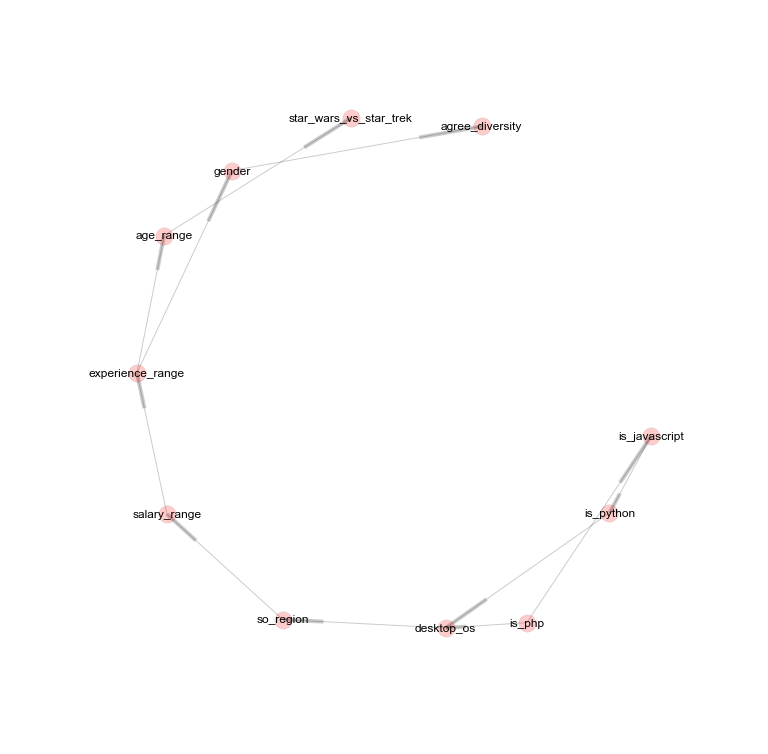

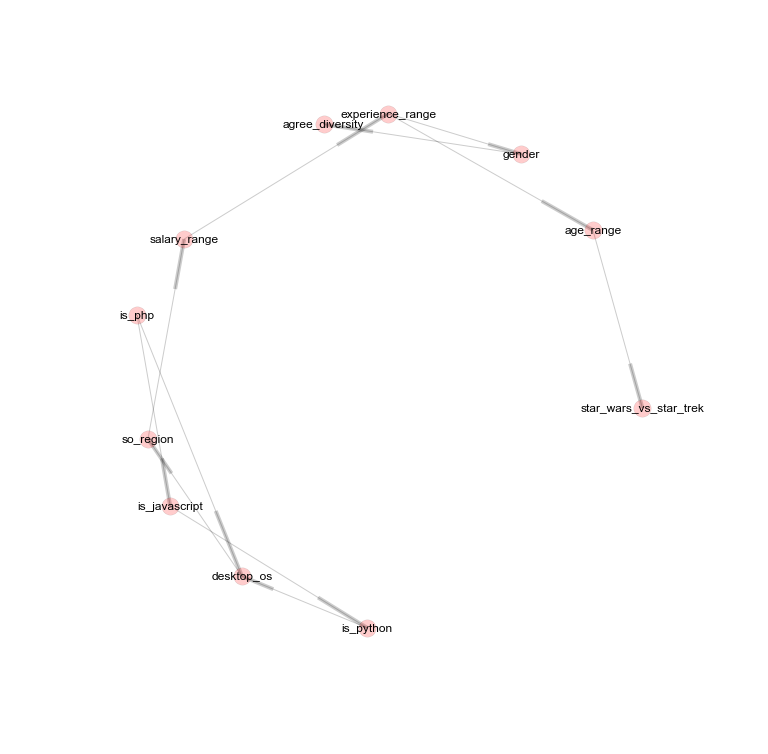

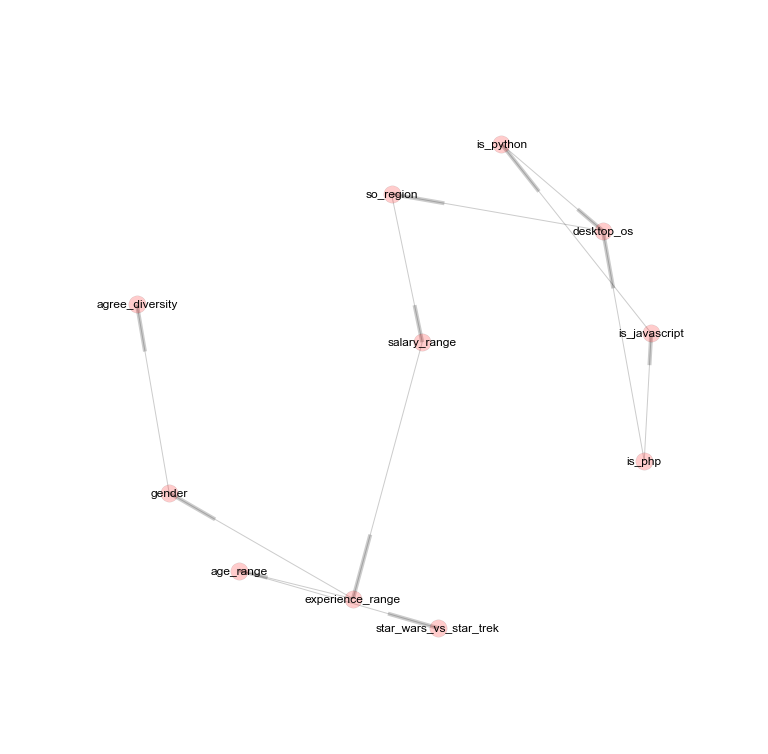

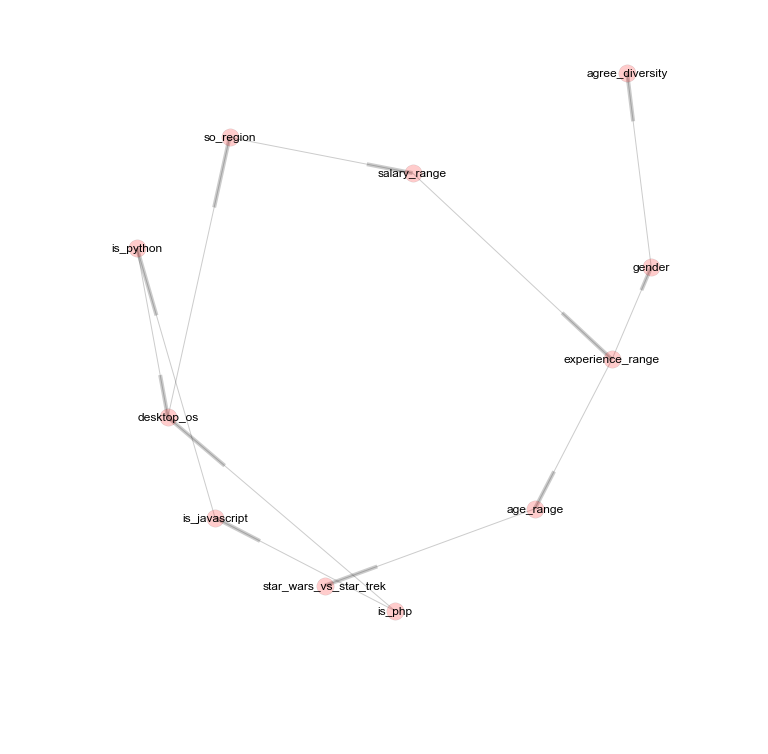

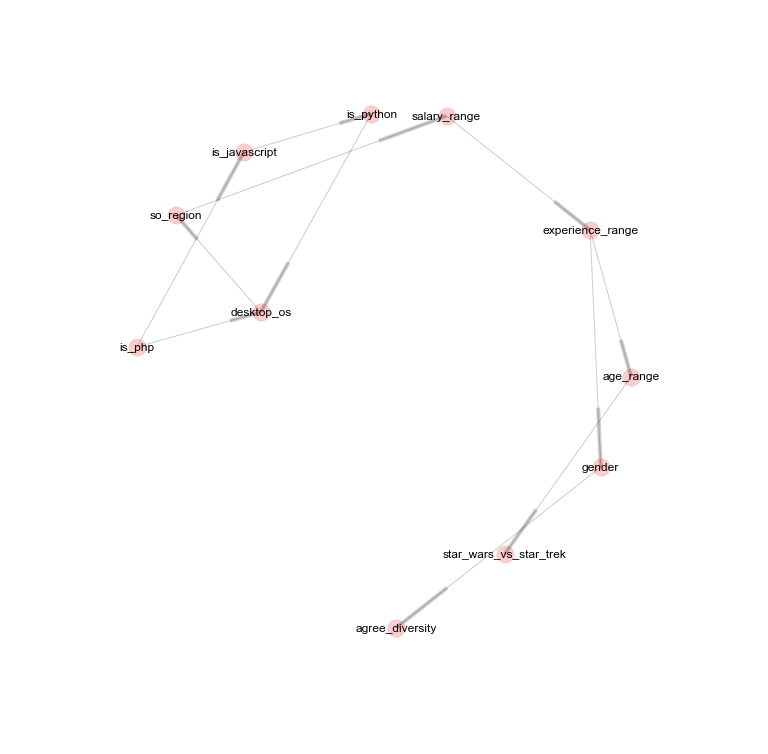

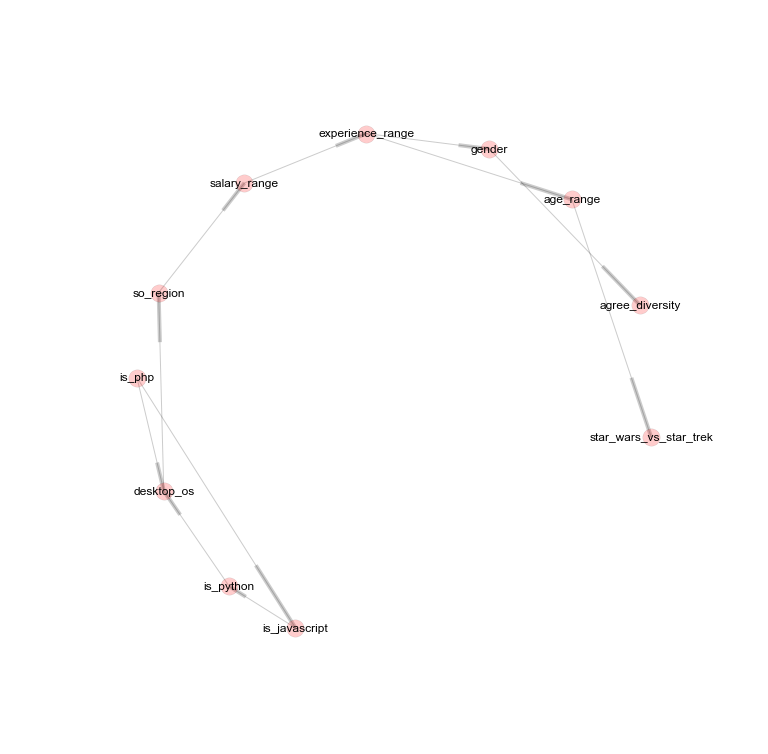

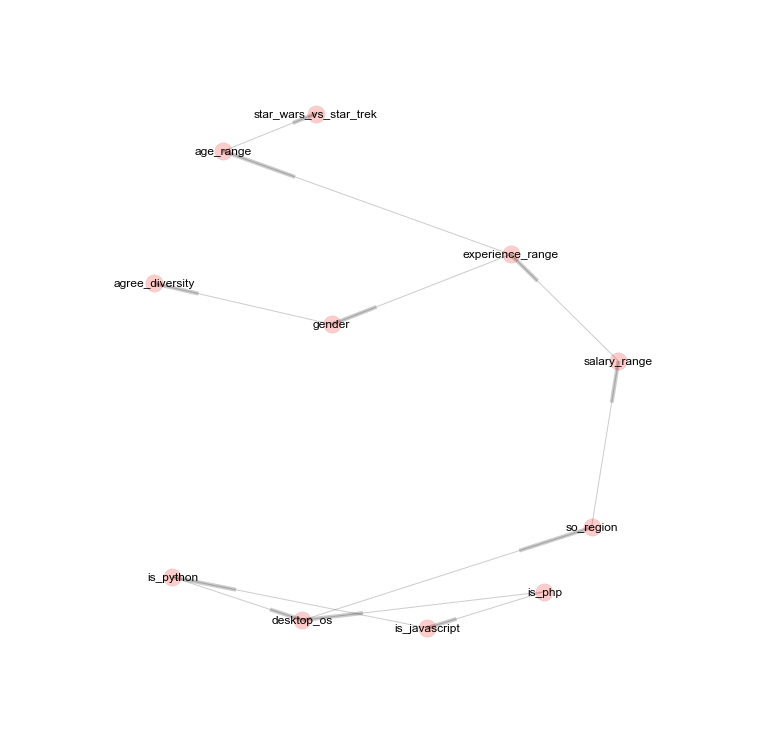

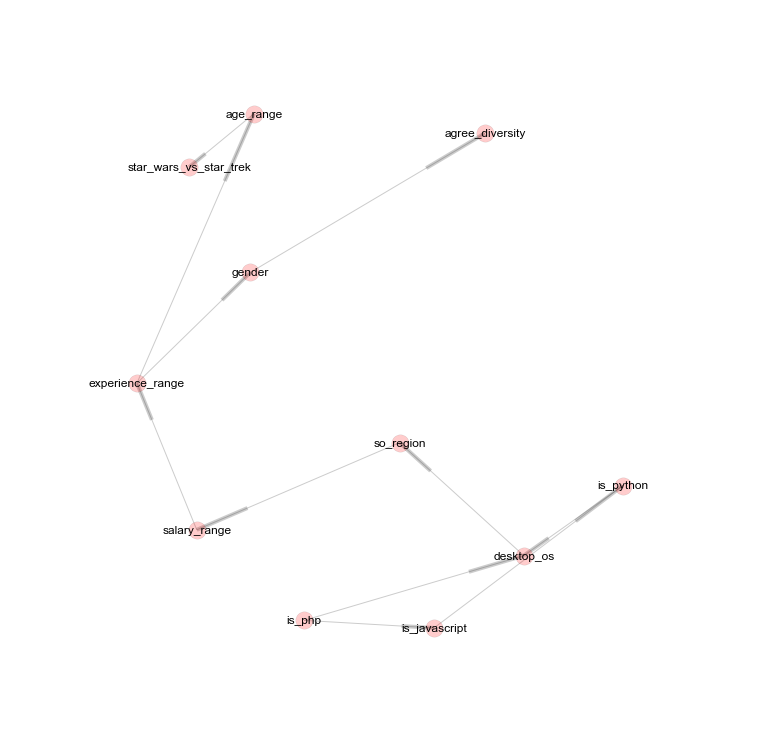

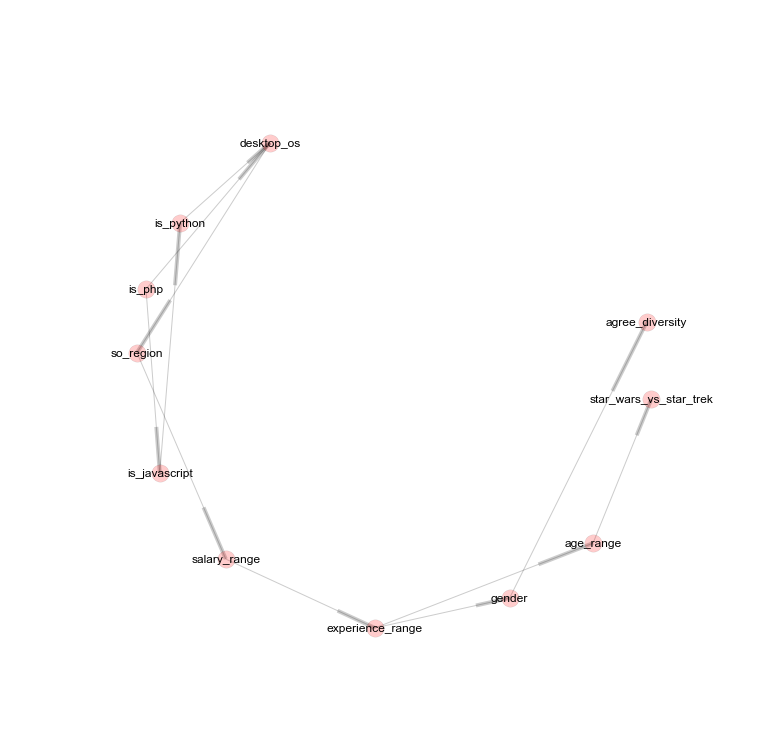

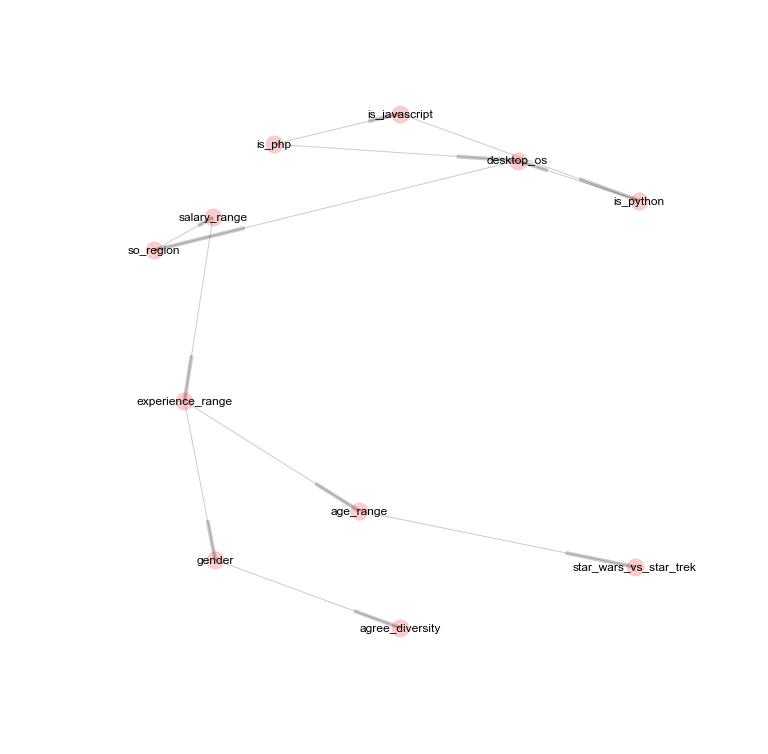

In [28]:
from tqdm import *
np.random.seed(42)
scores = np.zeros((3, 10))
for i, tabu_length in enumerate(tqdm(range(10))):
    hc = HillClimbSearch(data, scoring_method=BicScore(data))
    best_model = hc.estimate(tabu_length=tabu_length)
    draw_graph(best_model)
    scores[:, i] = print_scores(best_model)


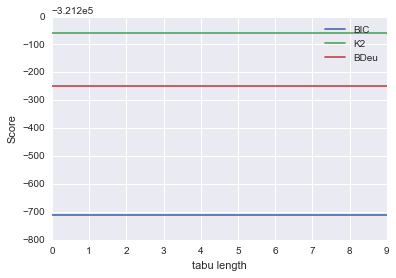

In [29]:
plt.figure()
X = list(range(10))
plt.plot(X, scores[0, :], label='BIC')
plt.plot(X, scores[1, :], label='K2')
plt.plot(X, scores[2, :], label='BDeu')
plt.xlabel('tabu length')
plt.ylabel('Score')
plt.legend()
plt.show()

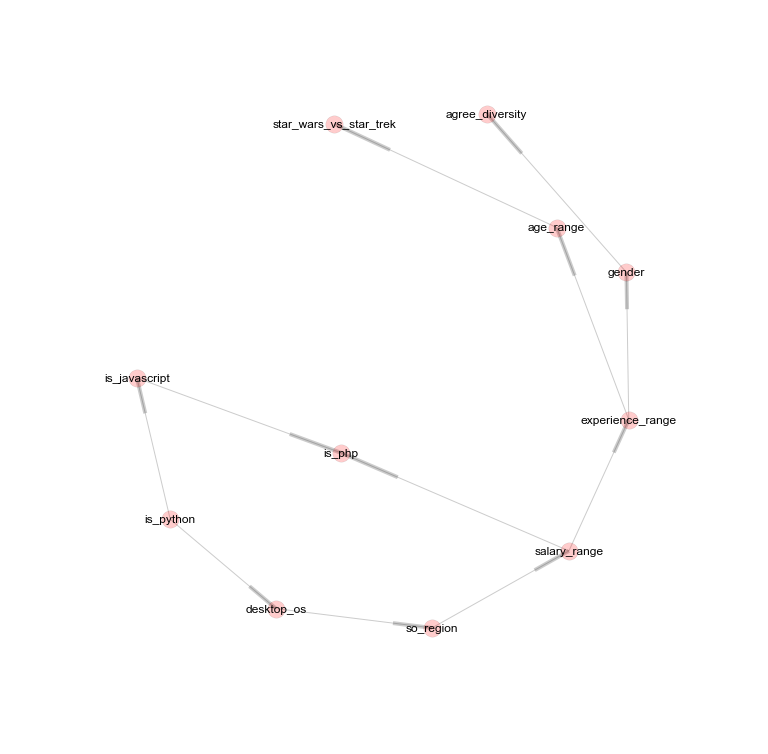

In [10]:
draw_graph(best_model)

D:\Anaconda\lib\site-packages\pgmpy-0.1.3-py3.5.egg\pgmpy\estimators\base.py:202: UserWarning: Insufficient data for testing age_range _|_ experience_range | ['star_wars_vs_star_trek', 'so_region', 'salary_range']. At least 68640 samples recommended, 41233 present.
  "At least {0} samples recommended, {1} present.".format(5 * num_params, len(self.data)))
D:\Anaconda\lib\site-packages\pgmpy-0.1.3-py3.5.egg\pgmpy\estimators\base.py:202: UserWarning: Insufficient data for testing age_range _|_ experience_range | ['is_python', 'so_region', 'salary_range']. At least 68640 samples recommended, 41233 present.
  "At least {0} samples recommended, {1} present.".format(5 * num_params, len(self.data)))
D:\Anaconda\lib\site-packages\pgmpy-0.1.3-py3.5.egg\pgmpy\estimators\base.py:202: UserWarning: Insufficient data for testing age_range _|_ so_region | ['experience_range', 'is_python', 'salary_range']. At least 79200 samples recommended, 41233 present.
  "At least {0} samples recommended, {1} prese

Undirected edges:  [('is_javascript', 'is_python'), ('is_javascript', 'is_php'), ('experience_range', 'so_region'), ('experience_range', 'age_range'), ('experience_range', 'salary_range'), ('so_region', 'age_range'), ('so_region', 'salary_range'), ('age_range', 'salary_range'), ('gender', 'agree_diversity'), ('desktop_os', 'is_python')]
PDAG edges:        [('is_javascript', 'is_python'), ('is_javascript', 'is_php'), ('experience_range', 'salary_range'), ('experience_range', 'so_region'), ('experience_range', 'age_range'), ('so_region', 'experience_range'), ('so_region', 'salary_range'), ('so_region', 'age_range'), ('age_range', 'experience_range'), ('age_range', 'so_region'), ('age_range', 'salary_range'), ('gender', 'agree_diversity'), ('desktop_os', 'is_python'), ('is_python', 'is_javascript'), ('is_python', 'desktop_os'), ('salary_range', 'experience_range'), ('salary_range', 'so_region'), ('salary_range', 'age_range'), ('is_php', 'is_javascript'), ('agree_diversity', 'gender')]
DAG

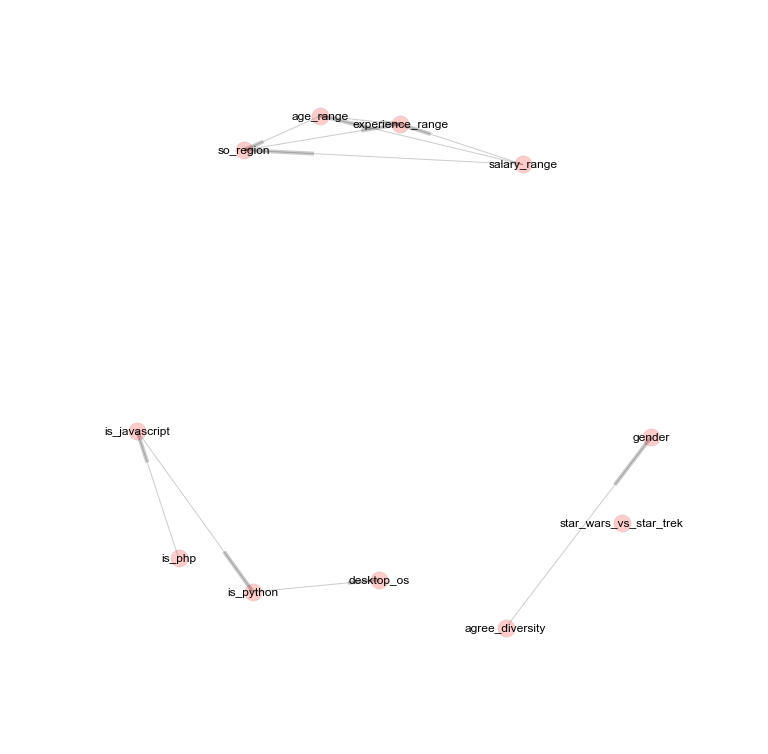

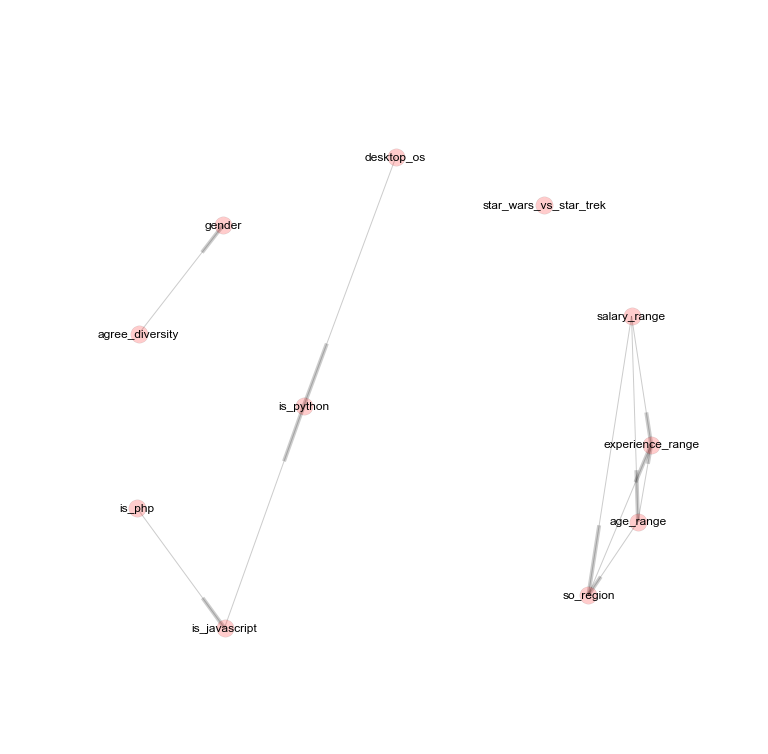

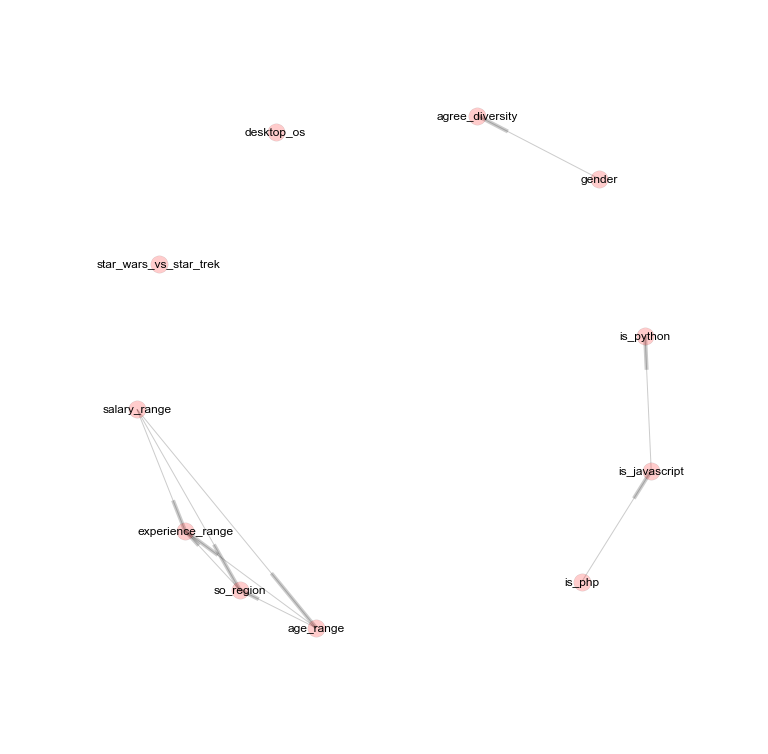

In [30]:
np.random.seed(42)
for alpha in [0.001, 0.01, 0.1]:
    est = ConstraintBasedEstimator(data)
    skel, seperating_sets = est.estimate_skeleton(significance_level=alpha)
    print("Undirected edges: ", skel.edges())

    pdag = est.skeleton_to_pdag(skel, seperating_sets)
    print("PDAG edges:       ", pdag.edges())

    model = est.pdag_to_dag(pdag)
    print("DAG edges:        ", model.edges())
    
    draw_graph(model)
    print('Significance %f' % alpha)
    print_scores(model)

In [18]:
bic = BicScore(data)
k2 = K2Score(data)
bdeu = BdeuScore(data, equivalent_sample_size=5)
print('K2: ', k2.score(model))
print('BIC', bic.score(model))
print('Bdeu', bdeu.score(model))

('K2: ', -322914.0673207193)
('BIC', -350620.47821670427)
('Bdeu', -329743.765572083)


Part 1) Skeleton:  [('is_javascript', 'is_python'), ('is_javascript', 'is_php'), ('experience_range', 'so_region'), ('experience_range', 'salary_range'), ('experience_range', 'gender'), ('experience_range', 'age_range'), ('so_region', 'salary_range'), ('so_region', 'age_range'), ('age_range', 'salary_range'), ('age_range', 'star_wars_vs_star_trek'), ('desktop_os', 'is_python'), ('desktop_os', 'agree_diversity')]
Part 2) Model:     [('is_javascript', 'is_python'), ('experience_range', 'gender'), ('experience_range', 'age_range'), ('so_region', 'salary_range'), ('age_range', 'star_wars_vs_star_trek'), ('desktop_os', 'agree_diversity'), ('is_python', 'desktop_os'), ('salary_range', 'experience_range'), ('is_php', 'is_javascript')]


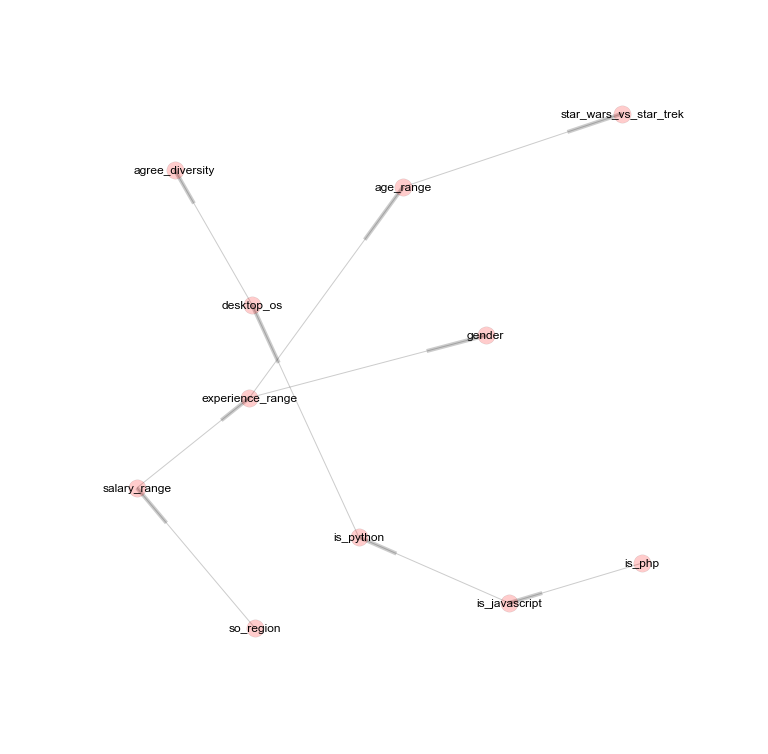

In [31]:
np.random.seed(42)
#mmhc = MmhcEstimator(data)
#skeleton = mmhc.mmpc()
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(skeleton, file)

# with open('model.pkl', 'rb') as file:
#     skeleton = pickle.load(file, encoding='latin1')
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data, scoring_method=BicScore(data))
model = hc.estimate(white_list=skeleton.to_directed().edges())
print("Part 2) Model:    ", model.edges())
draw_graph(model)

In [32]:
bic = BicScore(data)
k2 = K2Score(data)
bdeu = BdeuScore(data, equivalent_sample_size=5)
print('K2: ', k2.score(model))
print('BIC', bic.score(model))
print('Bdeu', bdeu.score(model))

K2:  -321670.4083188548
BIC -322223.203759
Bdeu -321948.8641458816


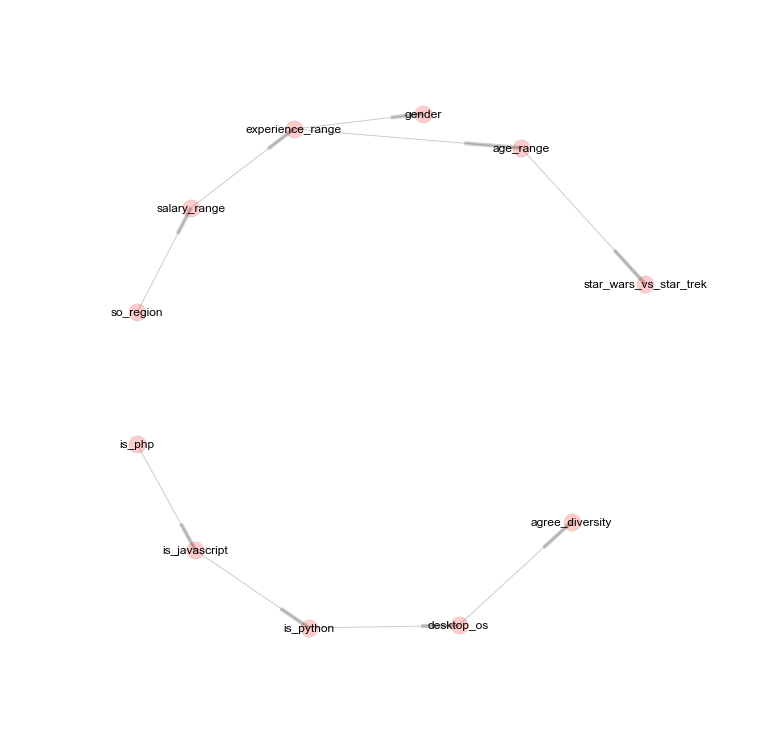

In [33]:
draw_graph(model)